In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from transformers import ViTForImageClassification, ViTFeatureExtractor
from tqdm import tqdm
import pandas as pd
import os
from datasets import DatasetDict, Dataset
from transformers import AutoImageProcessor
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [2]:
# Define the paths to your training and testing datasets
train_data_dir = "C:/Users/Amir/Desktop/skin cancer paper/skin cancer isic/Skin Cancer ISIC/Skin cancer ISIC The International Skin Imaging Collaboration/train"  # Replace with the path to your training dataset
test_data_dir = "C:/Users/Amir/Desktop/skin cancer paper/skin cancer isic/Skin Cancer ISIC/Skin cancer ISIC The International Skin Imaging Collaboration/test"  # Replace with the path to your testing dataset

In [11]:
# Load the ViT feature extractor
model_name = "google/vit-base-patch16-224"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)


# Hybrid approach (augmentations + feature extractor)
augmentations = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
])



# Use ViTFeatureExtractor for final preprocessing
def preprocess_image(image):
    augmented = augmentations(image)
    return feature_extractor(augmented, return_tensors="pt")["pixel_values"].squeeze(0)


# Load datasets with ViT preprocessing
train_dataset = datasets.ImageFolder(train_data_dir, transform=preprocess_image)
test_dataset = datasets.ImageFolder(test_data_dir, transform=preprocess_image)

# Split training data into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check classes (ensure consistency)
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

# Print dataset sizes
print(f"Train size: {len(train_subset)}")
print(f"Val size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")

Number of classes: 9
Train size: 1791
Val size: 448
Test size: 118


In [12]:
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([9]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [14]:
import torch
import torch.optim as optim
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from transformers import ViTForImageClassification, ViTConfig


# Define the criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer with weight decay (L2 regularization)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# CSV file to store the metrics
csv_filename = "training_metrics.csv"
df = pd.DataFrame(columns=["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])
df.to_csv(csv_filename, index=False)  # Create an empty file with headers


for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Wrap train_loader with tqdm for a progress bar
    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training")
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # Forward pass (no need to access .logits for ViT, use the outputs directly)
        outputs = model(images)
        logits = outputs.logits  # Get logits from model output
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update the progress bar description with current loss and accuracy
        train_loop.set_postfix(loss=loss.item(), accuracy=(correct / total) * 100)
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    # Wrap val_loader with tqdm for a progress bar
    val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation")
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            logits = outputs.logits  # Get logits from model output
            loss = criterion(logits, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update the progress bar description with current loss and accuracy
            val_loop.set_postfix(loss=loss.item(), accuracy=(correct / total) * 100)
    
    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Step the scheduler based on validation loss
    scheduler.step(val_loss)

    # Save the metrics to a CSV file
    epoch_data = {
        "Epoch": epoch + 1,
        "Train Loss": train_loss,
        "Train Accuracy": train_accuracy,
        "Val Loss": val_loss,
        "Val Accuracy": val_accuracy
    }
    
    df = pd.DataFrame([epoch_data])  # Convert dictionary to DataFrame
    df.to_csv(csv_filename, mode='a', header=False, index=False)  # Append to CSV


Epoch [1/100] Training: 100%|██████████| 56/56 [01:01<00:00,  1.09s/it, accuracy=23.5, loss=1.98]


Epoch [1/100], Train Loss: 2.0578, Train Accuracy: 23.45%


Epoch [1/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s, accuracy=27.7, loss=1.87]


Epoch [1/100], Val Loss: 1.8232, Val Accuracy: 27.68%


Epoch [2/100] Training: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, accuracy=34.1, loss=1.71]


Epoch [2/100], Train Loss: 1.7271, Train Accuracy: 34.06%


Epoch [2/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s, accuracy=27.9, loss=1.73]


Epoch [2/100], Val Loss: 1.7779, Val Accuracy: 27.90%


Epoch [3/100] Training: 100%|██████████| 56/56 [01:01<00:00,  1.09s/it, accuracy=39.4, loss=1.73]


Epoch [3/100], Train Loss: 1.6461, Train Accuracy: 39.42%


Epoch [3/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.50it/s, accuracy=32.4, loss=1.98]


Epoch [3/100], Val Loss: 1.7443, Val Accuracy: 32.37%


Epoch [4/100] Training: 100%|██████████| 56/56 [01:12<00:00,  1.30s/it, accuracy=40, loss=1.55]  


Epoch [4/100], Train Loss: 1.6466, Train Accuracy: 40.03%


Epoch [4/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s, accuracy=40.8, loss=1.65]


Epoch [4/100], Val Loss: 1.6463, Val Accuracy: 40.85%


Epoch [5/100] Training: 100%|██████████| 56/56 [01:12<00:00,  1.29s/it, accuracy=43.6, loss=1.52]


Epoch [5/100], Train Loss: 1.5563, Train Accuracy: 43.61%


Epoch [5/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s, accuracy=45.1, loss=1.49]


Epoch [5/100], Val Loss: 1.4865, Val Accuracy: 45.09%


Epoch [6/100] Training: 100%|██████████| 56/56 [01:13<00:00,  1.31s/it, accuracy=47.9, loss=1.47]


Epoch [6/100], Train Loss: 1.4585, Train Accuracy: 47.85%


Epoch [6/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s, accuracy=41.7, loss=1.7] 


Epoch [6/100], Val Loss: 1.5457, Val Accuracy: 41.74%


Epoch [7/100] Training: 100%|██████████| 56/56 [01:11<00:00,  1.28s/it, accuracy=49.6, loss=1.53] 


Epoch [7/100], Train Loss: 1.3874, Train Accuracy: 49.64%


Epoch [7/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s, accuracy=49.6, loss=1.51]


Epoch [7/100], Val Loss: 1.4127, Val Accuracy: 49.55%


Epoch [8/100] Training: 100%|██████████| 56/56 [01:13<00:00,  1.32s/it, accuracy=49.2, loss=1.45]


Epoch [8/100], Train Loss: 1.4110, Train Accuracy: 49.25%


Epoch [8/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s, accuracy=50, loss=1.54]  


Epoch [8/100], Val Loss: 1.3864, Val Accuracy: 50.00%


Epoch [9/100] Training: 100%|██████████| 56/56 [01:14<00:00,  1.34s/it, accuracy=50.5, loss=1.47]


Epoch [9/100], Train Loss: 1.3717, Train Accuracy: 50.47%


Epoch [9/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s, accuracy=48.7, loss=1.75]


Epoch [9/100], Val Loss: 1.4419, Val Accuracy: 48.66%


Epoch [10/100] Training: 100%|██████████| 56/56 [01:11<00:00,  1.28s/it, accuracy=51.4, loss=1.67]


Epoch [10/100], Train Loss: 1.3655, Train Accuracy: 51.42%


Epoch [10/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s, accuracy=48, loss=1.61]  


Epoch [10/100], Val Loss: 1.4468, Val Accuracy: 47.99%


Epoch [11/100] Training: 100%|██████████| 56/56 [01:12<00:00,  1.30s/it, accuracy=51.8, loss=1.28]


Epoch [11/100], Train Loss: 1.3017, Train Accuracy: 51.76%


Epoch [11/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s, accuracy=52.7, loss=1.37]


Epoch [11/100], Val Loss: 1.3072, Val Accuracy: 52.68%


Epoch [12/100] Training: 100%|██████████| 56/56 [01:13<00:00,  1.31s/it, accuracy=53.3, loss=1.1]  


Epoch [12/100], Train Loss: 1.3395, Train Accuracy: 53.27%


Epoch [12/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s, accuracy=50, loss=1.55]  


Epoch [12/100], Val Loss: 1.3831, Val Accuracy: 50.00%


Epoch [13/100] Training: 100%|██████████| 56/56 [01:12<00:00,  1.29s/it, accuracy=53.3, loss=1.44] 


Epoch [13/100], Train Loss: 1.3008, Train Accuracy: 53.32%


Epoch [13/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s, accuracy=48.4, loss=1.6] 


Epoch [13/100], Val Loss: 1.4095, Val Accuracy: 48.44%


Epoch [14/100] Training: 100%|██████████| 56/56 [01:12<00:00,  1.29s/it, accuracy=52.3, loss=1.23] 


Epoch [14/100], Train Loss: 1.3148, Train Accuracy: 52.26%


Epoch [14/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s, accuracy=52.7, loss=1.45] 


Epoch [14/100], Val Loss: 1.2831, Val Accuracy: 52.68%


Epoch [15/100] Training: 100%|██████████| 56/56 [01:12<00:00,  1.29s/it, accuracy=51.9, loss=0.973]


Epoch [15/100], Train Loss: 1.3104, Train Accuracy: 51.93%


Epoch [15/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s, accuracy=52, loss=1.35]  


Epoch [15/100], Val Loss: 1.3027, Val Accuracy: 52.01%


Epoch [16/100] Training: 100%|██████████| 56/56 [01:12<00:00,  1.30s/it, accuracy=54.7, loss=1.29] 


Epoch [16/100], Train Loss: 1.2700, Train Accuracy: 54.66%


Epoch [16/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s, accuracy=51.3, loss=1.42]


Epoch [16/100], Val Loss: 1.3435, Val Accuracy: 51.34%


Epoch [17/100] Training: 100%|██████████| 56/56 [01:12<00:00,  1.30s/it, accuracy=53.6, loss=1.44] 


Epoch [17/100], Train Loss: 1.2515, Train Accuracy: 53.60%


Epoch [17/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s, accuracy=54.9, loss=1.28]


Epoch [17/100], Val Loss: 1.2468, Val Accuracy: 54.91%


Epoch [18/100] Training: 100%|██████████| 56/56 [01:13<00:00,  1.31s/it, accuracy=55.9, loss=1.45] 


Epoch [18/100], Train Loss: 1.2156, Train Accuracy: 55.95%


Epoch [18/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s, accuracy=53.1, loss=1.28]


Epoch [18/100], Val Loss: 1.2847, Val Accuracy: 53.12%


Epoch [19/100] Training: 100%|██████████| 56/56 [01:12<00:00,  1.30s/it, accuracy=55.6, loss=1.39] 


Epoch [19/100], Train Loss: 1.2136, Train Accuracy: 55.56%


Epoch [19/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s, accuracy=54.2, loss=1.31]


Epoch [19/100], Val Loss: 1.2344, Val Accuracy: 54.24%


Epoch [20/100] Training: 100%|██████████| 56/56 [01:12<00:00,  1.30s/it, accuracy=56.3, loss=0.944]


Epoch [20/100], Train Loss: 1.2003, Train Accuracy: 56.34%


Epoch [20/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s, accuracy=52.7, loss=1.42]


Epoch [20/100], Val Loss: 1.2350, Val Accuracy: 52.68%


Epoch [21/100] Training: 100%|██████████| 56/56 [01:14<00:00,  1.34s/it, accuracy=56.6, loss=1.24] 


Epoch [21/100], Train Loss: 1.1860, Train Accuracy: 56.62%


Epoch [21/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s, accuracy=54.5, loss=1.33]


Epoch [21/100], Val Loss: 1.2560, Val Accuracy: 54.46%


Epoch [22/100] Training: 100%|██████████| 56/56 [01:12<00:00,  1.30s/it, accuracy=55.3, loss=1.34] 


Epoch [22/100], Train Loss: 1.2109, Train Accuracy: 55.28%


Epoch [22/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s, accuracy=50.9, loss=1.4]  


Epoch [22/100], Val Loss: 1.3139, Val Accuracy: 50.89%


Epoch [23/100] Training: 100%|██████████| 56/56 [01:13<00:00,  1.31s/it, accuracy=57.4, loss=1.1]  


Epoch [23/100], Train Loss: 1.1952, Train Accuracy: 57.40%


Epoch [23/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s, accuracy=54, loss=1.43]  


Epoch [23/100], Val Loss: 1.2765, Val Accuracy: 54.02%


Epoch [24/100] Training: 100%|██████████| 56/56 [01:12<00:00,  1.29s/it, accuracy=56.9, loss=1.03] 


Epoch [24/100], Train Loss: 1.1715, Train Accuracy: 56.90%


Epoch [24/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s, accuracy=55.6, loss=1.32]


Epoch [24/100], Val Loss: 1.2429, Val Accuracy: 55.58%


Epoch [25/100] Training: 100%|██████████| 56/56 [01:12<00:00,  1.29s/it, accuracy=57.7, loss=1.39] 


Epoch [25/100], Train Loss: 1.1628, Train Accuracy: 57.73%


Epoch [25/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s, accuracy=54.5, loss=1.31]


Epoch [25/100], Val Loss: 1.2574, Val Accuracy: 54.46%


Epoch [26/100] Training: 100%|██████████| 56/56 [01:03<00:00,  1.13s/it, accuracy=61.8, loss=0.778]


Epoch [26/100], Train Loss: 1.0435, Train Accuracy: 61.81%


Epoch [26/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s, accuracy=57.8, loss=1.34] 


Epoch [26/100], Val Loss: 1.1181, Val Accuracy: 57.81%


Epoch [27/100] Training: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it, accuracy=63.4, loss=0.975]


Epoch [27/100], Train Loss: 1.0032, Train Accuracy: 63.43%


Epoch [27/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.74it/s, accuracy=59.8, loss=1.28] 


Epoch [27/100], Val Loss: 1.1486, Val Accuracy: 59.82%


Epoch [28/100] Training: 100%|██████████| 56/56 [00:58<00:00,  1.04s/it, accuracy=64.3, loss=1.12] 


Epoch [28/100], Train Loss: 0.9744, Train Accuracy: 64.32%


Epoch [28/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s, accuracy=57.1, loss=1.28]


Epoch [28/100], Val Loss: 1.1020, Val Accuracy: 57.14%


Epoch [29/100] Training: 100%|██████████| 56/56 [01:05<00:00,  1.18s/it, accuracy=66.3, loss=1.1]  


Epoch [29/100], Train Loss: 0.9345, Train Accuracy: 66.28%


Epoch [29/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s, accuracy=60.3, loss=1.2]  


Epoch [29/100], Val Loss: 1.1373, Val Accuracy: 60.27%


Epoch [30/100] Training: 100%|██████████| 56/56 [01:02<00:00,  1.11s/it, accuracy=65.3, loss=0.981]


Epoch [30/100], Train Loss: 0.9653, Train Accuracy: 65.27%


Epoch [30/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.74it/s, accuracy=58.7, loss=1.28] 


Epoch [30/100], Val Loss: 1.1304, Val Accuracy: 58.71%


Epoch [31/100] Training: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, accuracy=65.9, loss=0.987]


Epoch [31/100], Train Loss: 0.9270, Train Accuracy: 65.88%


Epoch [31/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.67it/s, accuracy=57.6, loss=1.39] 


Epoch [31/100], Val Loss: 1.1690, Val Accuracy: 57.59%


Epoch [32/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.06s/it, accuracy=66.1, loss=1.07] 


Epoch [32/100], Train Loss: 0.9273, Train Accuracy: 66.05%


Epoch [32/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s, accuracy=60, loss=1.17]   


Epoch [32/100], Val Loss: 1.0956, Val Accuracy: 60.04%


Epoch [33/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.05s/it, accuracy=65.8, loss=0.618]


Epoch [33/100], Train Loss: 0.9156, Train Accuracy: 65.83%


Epoch [33/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s, accuracy=60, loss=1.26]   


Epoch [33/100], Val Loss: 1.1245, Val Accuracy: 60.04%


Epoch [34/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=66.2, loss=0.692]


Epoch [34/100], Train Loss: 0.9085, Train Accuracy: 66.16%


Epoch [34/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s, accuracy=61.8, loss=1.3]  


Epoch [34/100], Val Loss: 1.1431, Val Accuracy: 61.83%


Epoch [35/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=67.8, loss=1.26] 


Epoch [35/100], Train Loss: 0.8895, Train Accuracy: 67.78%


Epoch [35/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s, accuracy=60.5, loss=1.34] 


Epoch [35/100], Val Loss: 1.0739, Val Accuracy: 60.49%


Epoch [36/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.06s/it, accuracy=68.6, loss=0.632]


Epoch [36/100], Train Loss: 0.8485, Train Accuracy: 68.62%


Epoch [36/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s, accuracy=63.2, loss=1.14] 


Epoch [36/100], Val Loss: 1.1027, Val Accuracy: 63.17%


Epoch [37/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=69.3, loss=0.551]


Epoch [37/100], Train Loss: 0.8591, Train Accuracy: 69.35%


Epoch [37/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s, accuracy=59.8, loss=1.3]  


Epoch [37/100], Val Loss: 1.0913, Val Accuracy: 59.82%


Epoch [38/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=69.8, loss=0.705]


Epoch [38/100], Train Loss: 0.8288, Train Accuracy: 69.79%


Epoch [38/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=61.2, loss=1.46] 


Epoch [38/100], Val Loss: 1.1275, Val Accuracy: 61.16%


Epoch [39/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.06s/it, accuracy=70.1, loss=0.851]


Epoch [39/100], Train Loss: 0.8261, Train Accuracy: 70.07%


Epoch [39/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s, accuracy=62.3, loss=1.38] 


Epoch [39/100], Val Loss: 1.1299, Val Accuracy: 62.28%


Epoch [40/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=69.7, loss=0.971]


Epoch [40/100], Train Loss: 0.8084, Train Accuracy: 69.74%


Epoch [40/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=60.5, loss=1.26] 


Epoch [40/100], Val Loss: 1.0481, Val Accuracy: 60.49%


Epoch [41/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=69.9, loss=0.773]


Epoch [41/100], Train Loss: 0.7948, Train Accuracy: 69.91%


Epoch [41/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=59.8, loss=1.3]  


Epoch [41/100], Val Loss: 1.1191, Val Accuracy: 59.82%


Epoch [42/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it, accuracy=71.3, loss=0.644]


Epoch [42/100], Train Loss: 0.7819, Train Accuracy: 71.30%


Epoch [42/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s, accuracy=61.6, loss=1.39] 


Epoch [42/100], Val Loss: 1.1393, Val Accuracy: 61.61%


Epoch [43/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=70.4, loss=0.799]


Epoch [43/100], Train Loss: 0.7845, Train Accuracy: 70.41%


Epoch [43/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s, accuracy=61.2, loss=1.34] 


Epoch [43/100], Val Loss: 1.1894, Val Accuracy: 61.16%


Epoch [44/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it, accuracy=71.6, loss=0.816]


Epoch [44/100], Train Loss: 0.7390, Train Accuracy: 71.64%


Epoch [44/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s, accuracy=64.5, loss=1.69] 


Epoch [44/100], Val Loss: 1.0873, Val Accuracy: 64.51%


Epoch [45/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it, accuracy=73.3, loss=0.731]


Epoch [45/100], Train Loss: 0.7379, Train Accuracy: 73.31%


Epoch [45/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s, accuracy=62.9, loss=1.21] 


Epoch [45/100], Val Loss: 1.1282, Val Accuracy: 62.95%


Epoch [46/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=72.9, loss=0.477]


Epoch [46/100], Train Loss: 0.7353, Train Accuracy: 72.86%


Epoch [46/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s, accuracy=60.9, loss=1.45] 


Epoch [46/100], Val Loss: 1.1298, Val Accuracy: 60.94%


Epoch [47/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it, accuracy=75.2, loss=0.595]


Epoch [47/100], Train Loss: 0.6859, Train Accuracy: 75.21%


Epoch [47/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s, accuracy=63.2, loss=1.42] 


Epoch [47/100], Val Loss: 1.0520, Val Accuracy: 63.17%


Epoch [48/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.06s/it, accuracy=76.4, loss=0.777]


Epoch [48/100], Train Loss: 0.6635, Train Accuracy: 76.44%


Epoch [48/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s, accuracy=62.3, loss=1.14] 


Epoch [48/100], Val Loss: 1.1356, Val Accuracy: 62.28%


Epoch [49/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it, accuracy=74.9, loss=0.493]


Epoch [49/100], Train Loss: 0.6826, Train Accuracy: 74.87%


Epoch [49/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s, accuracy=65.2, loss=1.22] 


Epoch [49/100], Val Loss: 1.0596, Val Accuracy: 65.18%


Epoch [50/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.09s/it, accuracy=76.4, loss=0.373]


Epoch [50/100], Train Loss: 0.6497, Train Accuracy: 76.38%


Epoch [50/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=63.8, loss=1.3]  


Epoch [50/100], Val Loss: 1.1202, Val Accuracy: 63.84%


Epoch [51/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it, accuracy=75.6, loss=0.689]


Epoch [51/100], Train Loss: 0.6655, Train Accuracy: 75.60%


Epoch [51/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s, accuracy=61.6, loss=1.49] 


Epoch [51/100], Val Loss: 1.1598, Val Accuracy: 61.61%


Epoch [52/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it, accuracy=75.8, loss=0.561]


Epoch [52/100], Train Loss: 0.6598, Train Accuracy: 75.82%


Epoch [52/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s, accuracy=63.4, loss=1.49] 


Epoch [52/100], Val Loss: 1.1392, Val Accuracy: 63.39%


Epoch [53/100] Training: 100%|██████████| 56/56 [01:01<00:00,  1.11s/it, accuracy=76.4, loss=0.785]


Epoch [53/100], Train Loss: 0.6385, Train Accuracy: 76.38%


Epoch [53/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s, accuracy=63.6, loss=1.25] 


Epoch [53/100], Val Loss: 1.1654, Val Accuracy: 63.62%


Epoch [54/100] Training: 100%|██████████| 56/56 [01:02<00:00,  1.11s/it, accuracy=76, loss=0.307]  


Epoch [54/100], Train Loss: 0.6359, Train Accuracy: 76.05%


Epoch [54/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s, accuracy=62.7, loss=1.45] 


Epoch [54/100], Val Loss: 1.1875, Val Accuracy: 62.72%


Epoch [55/100] Training: 100%|██████████| 56/56 [01:02<00:00,  1.11s/it, accuracy=77.5, loss=0.549]


Epoch [55/100], Train Loss: 0.6302, Train Accuracy: 77.50%


Epoch [55/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s, accuracy=64.1, loss=1.28] 


Epoch [55/100], Val Loss: 1.0889, Val Accuracy: 64.06%


Epoch [56/100] Training: 100%|██████████| 56/56 [01:03<00:00,  1.14s/it, accuracy=77.3, loss=0.33] 


Epoch [56/100], Train Loss: 0.6174, Train Accuracy: 77.33%


Epoch [56/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.54it/s, accuracy=62.5, loss=1.29] 


Epoch [56/100], Val Loss: 1.1100, Val Accuracy: 62.50%


Epoch [57/100] Training: 100%|██████████| 56/56 [01:04<00:00,  1.15s/it, accuracy=77.2, loss=0.47] 


Epoch [57/100], Train Loss: 0.6235, Train Accuracy: 77.16%


Epoch [57/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=62.1, loss=1.42] 


Epoch [57/100], Val Loss: 1.1341, Val Accuracy: 62.05%


Epoch [58/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=76.4, loss=0.632]


Epoch [58/100], Train Loss: 0.6387, Train Accuracy: 76.44%


Epoch [58/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s, accuracy=63.4, loss=1.4]  


Epoch [58/100], Val Loss: 1.0884, Val Accuracy: 63.39%


Epoch [59/100] Training: 100%|██████████| 56/56 [01:02<00:00,  1.12s/it, accuracy=77.4, loss=0.703]


Epoch [59/100], Train Loss: 0.6416, Train Accuracy: 77.39%


Epoch [59/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s, accuracy=62.5, loss=1.25] 


Epoch [59/100], Val Loss: 1.0598, Val Accuracy: 62.50%


Epoch [60/100] Training: 100%|██████████| 56/56 [01:01<00:00,  1.09s/it, accuracy=77, loss=0.516]  


Epoch [60/100], Train Loss: 0.6238, Train Accuracy: 77.00%


Epoch [60/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=61.8, loss=1.37] 


Epoch [60/100], Val Loss: 1.1874, Val Accuracy: 61.83%


Epoch [61/100] Training: 100%|██████████| 56/56 [01:01<00:00,  1.09s/it, accuracy=76.4, loss=0.574]


Epoch [61/100], Train Loss: 0.6335, Train Accuracy: 76.44%


Epoch [61/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.58it/s, accuracy=63.2, loss=1.37] 


Epoch [61/100], Val Loss: 1.0713, Val Accuracy: 63.17%


Epoch [62/100] Training: 100%|██████████| 56/56 [01:01<00:00,  1.10s/it, accuracy=76.7, loss=0.618]


Epoch [62/100], Train Loss: 0.6155, Train Accuracy: 76.72%


Epoch [62/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.58it/s, accuracy=60.3, loss=1.48] 


Epoch [62/100], Val Loss: 1.1460, Val Accuracy: 60.27%


Epoch [63/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it, accuracy=76.5, loss=0.46] 


Epoch [63/100], Train Loss: 0.6273, Train Accuracy: 76.55%


Epoch [63/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s, accuracy=61.6, loss=1.47] 


Epoch [63/100], Val Loss: 1.1586, Val Accuracy: 61.61%


Epoch [64/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.09s/it, accuracy=77.8, loss=0.577]


Epoch [64/100], Train Loss: 0.6074, Train Accuracy: 77.78%


Epoch [64/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s, accuracy=62.9, loss=1.11] 


Epoch [64/100], Val Loss: 1.1158, Val Accuracy: 62.95%


Epoch [65/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.06s/it, accuracy=77.2, loss=0.538]


Epoch [65/100], Train Loss: 0.6173, Train Accuracy: 77.22%


Epoch [65/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s, accuracy=63.4, loss=1.23] 


Epoch [65/100], Val Loss: 1.1295, Val Accuracy: 63.39%


Epoch [66/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=77.4, loss=0.807]


Epoch [66/100], Train Loss: 0.6095, Train Accuracy: 77.44%


Epoch [66/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s, accuracy=62.5, loss=1.38] 


Epoch [66/100], Val Loss: 1.0889, Val Accuracy: 62.50%


Epoch [67/100] Training: 100%|██████████| 56/56 [01:05<00:00,  1.18s/it, accuracy=78, loss=0.644]  


Epoch [67/100], Train Loss: 0.6310, Train Accuracy: 78.00%


Epoch [67/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s, accuracy=60.7, loss=1.43] 


Epoch [67/100], Val Loss: 1.1720, Val Accuracy: 60.71%


Epoch [68/100] Training: 100%|██████████| 56/56 [01:04<00:00,  1.15s/it, accuracy=75.9, loss=0.506]


Epoch [68/100], Train Loss: 0.6433, Train Accuracy: 75.94%


Epoch [68/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.55it/s, accuracy=62.1, loss=1.25] 


Epoch [68/100], Val Loss: 1.0986, Val Accuracy: 62.05%


Epoch [69/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it, accuracy=77.4, loss=0.619]


Epoch [69/100], Train Loss: 0.6258, Train Accuracy: 77.39%


Epoch [69/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.72it/s, accuracy=62.5, loss=1.33] 


Epoch [69/100], Val Loss: 1.1198, Val Accuracy: 62.50%


Epoch [70/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.05s/it, accuracy=77.1, loss=0.632]


Epoch [70/100], Train Loss: 0.6107, Train Accuracy: 77.05%


Epoch [70/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s, accuracy=61.8, loss=1.25] 


Epoch [70/100], Val Loss: 1.1411, Val Accuracy: 61.83%


Epoch [71/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=77.9, loss=0.514]


Epoch [71/100], Train Loss: 0.6131, Train Accuracy: 77.89%


Epoch [71/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s, accuracy=62.1, loss=1.34] 


Epoch [71/100], Val Loss: 1.1222, Val Accuracy: 62.05%


Epoch [72/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.06s/it, accuracy=77.2, loss=0.567]


Epoch [72/100], Train Loss: 0.6462, Train Accuracy: 77.22%


Epoch [72/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s, accuracy=63.2, loss=1.49] 


Epoch [72/100], Val Loss: 1.1571, Val Accuracy: 63.17%


Epoch [73/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=76.8, loss=0.753]


Epoch [73/100], Train Loss: 0.6356, Train Accuracy: 76.83%


Epoch [73/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s, accuracy=63.6, loss=1.42] 


Epoch [73/100], Val Loss: 1.1076, Val Accuracy: 63.62%


Epoch [74/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it, accuracy=77.4, loss=0.694]


Epoch [74/100], Train Loss: 0.6295, Train Accuracy: 77.39%


Epoch [74/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s, accuracy=65.8, loss=1.5]  


Epoch [74/100], Val Loss: 1.1469, Val Accuracy: 65.85%


Epoch [75/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.09s/it, accuracy=76.7, loss=0.887]


Epoch [75/100], Train Loss: 0.6317, Train Accuracy: 76.66%


Epoch [75/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=63.2, loss=1.57]


Epoch [75/100], Val Loss: 1.1265, Val Accuracy: 63.17%


Epoch [76/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=76.8, loss=0.896]


Epoch [76/100], Train Loss: 0.6349, Train Accuracy: 76.77%


Epoch [76/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s, accuracy=62.7, loss=1.57] 


Epoch [76/100], Val Loss: 1.2082, Val Accuracy: 62.72%


Epoch [77/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it, accuracy=76.7, loss=0.751]


Epoch [77/100], Train Loss: 0.6403, Train Accuracy: 76.72%


Epoch [77/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s, accuracy=62.7, loss=1.52] 


Epoch [77/100], Val Loss: 1.1658, Val Accuracy: 62.72%


Epoch [78/100] Training: 100%|██████████| 56/56 [01:01<00:00,  1.10s/it, accuracy=77.9, loss=0.581]


Epoch [78/100], Train Loss: 0.6198, Train Accuracy: 77.95%


Epoch [78/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s, accuracy=63.8, loss=1.49] 


Epoch [78/100], Val Loss: 1.1157, Val Accuracy: 63.84%


Epoch [79/100] Training: 100%|██████████| 56/56 [01:01<00:00,  1.10s/it, accuracy=78, loss=0.662]  


Epoch [79/100], Train Loss: 0.6279, Train Accuracy: 78.00%


Epoch [79/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=59.8, loss=1.53] 


Epoch [79/100], Val Loss: 1.1825, Val Accuracy: 59.82%


Epoch [80/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it, accuracy=76.8, loss=0.723]


Epoch [80/100], Train Loss: 0.6417, Train Accuracy: 76.83%


Epoch [80/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=63.2, loss=1.46] 


Epoch [80/100], Val Loss: 1.1351, Val Accuracy: 63.17%


Epoch [81/100] Training: 100%|██████████| 56/56 [01:01<00:00,  1.09s/it, accuracy=77.2, loss=0.553]


Epoch [81/100], Train Loss: 0.6381, Train Accuracy: 77.22%


Epoch [81/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s, accuracy=62.1, loss=1.23] 


Epoch [81/100], Val Loss: 1.1318, Val Accuracy: 62.05%


Epoch [82/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it, accuracy=76.9, loss=0.415]


Epoch [82/100], Train Loss: 0.6152, Train Accuracy: 76.88%


Epoch [82/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s, accuracy=63.4, loss=1.3]  


Epoch [82/100], Val Loss: 1.1030, Val Accuracy: 63.39%


Epoch [83/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=77.7, loss=0.516]


Epoch [83/100], Train Loss: 0.6291, Train Accuracy: 77.72%


Epoch [83/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s, accuracy=66.3, loss=1.34] 


Epoch [83/100], Val Loss: 1.0519, Val Accuracy: 66.29%


Epoch [84/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it, accuracy=76.9, loss=0.552]


Epoch [84/100], Train Loss: 0.6379, Train Accuracy: 76.94%


Epoch [84/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s, accuracy=62.9, loss=1.45] 


Epoch [84/100], Val Loss: 1.1260, Val Accuracy: 62.95%


Epoch [85/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=78.2, loss=0.613]


Epoch [85/100], Train Loss: 0.6209, Train Accuracy: 78.17%


Epoch [85/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s, accuracy=64.5, loss=1.2]  


Epoch [85/100], Val Loss: 1.1388, Val Accuracy: 64.51%


Epoch [86/100] Training: 100%|██████████| 56/56 [01:01<00:00,  1.09s/it, accuracy=77.6, loss=0.338]


Epoch [86/100], Train Loss: 0.6222, Train Accuracy: 77.61%


Epoch [86/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s, accuracy=66.5, loss=1.33] 


Epoch [86/100], Val Loss: 1.0597, Val Accuracy: 66.52%


Epoch [87/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it, accuracy=77.4, loss=0.772]


Epoch [87/100], Train Loss: 0.6320, Train Accuracy: 77.44%


Epoch [87/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s, accuracy=62.7, loss=1.13] 


Epoch [87/100], Val Loss: 1.1553, Val Accuracy: 62.72%


Epoch [88/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it, accuracy=77.1, loss=0.546]


Epoch [88/100], Train Loss: 0.6155, Train Accuracy: 77.05%


Epoch [88/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=62.7, loss=1.35] 


Epoch [88/100], Val Loss: 1.1643, Val Accuracy: 62.72%


Epoch [89/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it, accuracy=77.2, loss=0.882]


Epoch [89/100], Train Loss: 0.6223, Train Accuracy: 77.16%


Epoch [89/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=62.5, loss=1.13] 


Epoch [89/100], Val Loss: 1.1387, Val Accuracy: 62.50%


Epoch [90/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it, accuracy=77.3, loss=0.821]


Epoch [90/100], Train Loss: 0.6378, Train Accuracy: 77.28%


Epoch [90/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s, accuracy=63.8, loss=1.33] 


Epoch [90/100], Val Loss: 1.0978, Val Accuracy: 63.84%


Epoch [91/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it, accuracy=76, loss=0.712]  


Epoch [91/100], Train Loss: 0.6398, Train Accuracy: 75.99%


Epoch [91/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=61.6, loss=1.4]  


Epoch [91/100], Val Loss: 1.1001, Val Accuracy: 61.61%


Epoch [92/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=76.9, loss=0.401]


Epoch [92/100], Train Loss: 0.6364, Train Accuracy: 76.88%


Epoch [92/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s, accuracy=63.4, loss=1.37] 


Epoch [92/100], Val Loss: 1.1506, Val Accuracy: 63.39%


Epoch [93/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=77.3, loss=0.887]


Epoch [93/100], Train Loss: 0.6304, Train Accuracy: 77.33%


Epoch [93/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s, accuracy=64.1, loss=1.31] 


Epoch [93/100], Val Loss: 1.1281, Val Accuracy: 64.06%


Epoch [94/100] Training: 100%|██████████| 56/56 [01:02<00:00,  1.12s/it, accuracy=76.7, loss=0.684]


Epoch [94/100], Train Loss: 0.6454, Train Accuracy: 76.66%


Epoch [94/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=63.2, loss=1.32] 


Epoch [94/100], Val Loss: 1.1452, Val Accuracy: 63.17%


Epoch [95/100] Training: 100%|██████████| 56/56 [01:01<00:00,  1.09s/it, accuracy=76.2, loss=0.623]


Epoch [95/100], Train Loss: 0.6365, Train Accuracy: 76.21%


Epoch [95/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=63.6, loss=1.54] 


Epoch [95/100], Val Loss: 1.1536, Val Accuracy: 63.62%


Epoch [96/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=76.5, loss=0.552]


Epoch [96/100], Train Loss: 0.6273, Train Accuracy: 76.49%


Epoch [96/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s, accuracy=65.6, loss=1.3]  


Epoch [96/100], Val Loss: 1.1203, Val Accuracy: 65.62%


Epoch [97/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=78.3, loss=0.782]


Epoch [97/100], Train Loss: 0.6091, Train Accuracy: 78.28%


Epoch [97/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s, accuracy=66.1, loss=1.22]


Epoch [97/100], Val Loss: 1.1016, Val Accuracy: 66.07%


Epoch [98/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.09s/it, accuracy=76.8, loss=0.234]


Epoch [98/100], Train Loss: 0.6361, Train Accuracy: 76.77%


Epoch [98/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=62.3, loss=1.61] 


Epoch [98/100], Val Loss: 1.1569, Val Accuracy: 62.28%


Epoch [99/100] Training: 100%|██████████| 56/56 [01:01<00:00,  1.09s/it, accuracy=76.7, loss=0.739]


Epoch [99/100], Train Loss: 0.6149, Train Accuracy: 76.72%


Epoch [99/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=62.7, loss=1.5]  


Epoch [99/100], Val Loss: 1.1686, Val Accuracy: 62.72%


Epoch [100/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it, accuracy=75.9, loss=0.859]


Epoch [100/100], Train Loss: 0.6550, Train Accuracy: 75.94%


Epoch [100/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s, accuracy=62.9, loss=1.35] 

Epoch [100/100], Val Loss: 1.1590, Val Accuracy: 62.95%


In [15]:
# Save the model's state dictionary
torch.save(model.state_dict(), "skin_cancer_model-ViT.pth")

print("Model saved successfully!")

Model saved successfully!


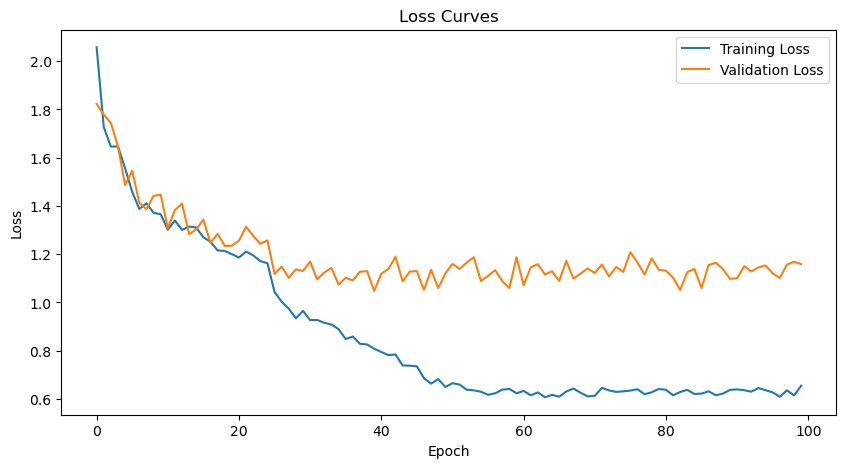

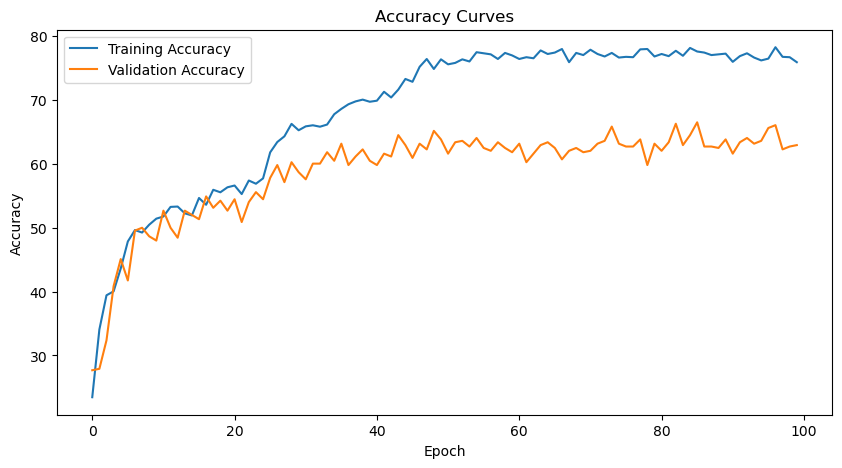

In [16]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

In [18]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize variables to track test loss and accuracy
test_loss = 0.0
correct = 0
total = 0

# Disable gradient computation for testing
with torch.no_grad():
    # Wrap test_loader with tqdm for a progress bar
    test_loop = tqdm(test_loader, desc="Testing ViT", ncols=100)
    for images, labels in test_loop:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the Vision Transformer model
        outputs = model(images)  # This will return an object, not just the logits
        
        # Access the logits from the model's output object
        logits = outputs.logits  # or use outputs['logits'] depending on the model output structure

        # Compute loss (cross-entropy loss with logits)
        loss = criterion(logits, labels)

        # Update test loss
        test_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update the progress bar with loss and accuracy
        test_loop.set_postfix(loss=test_loss/total, accuracy=(correct / total) * 100)

# Compute average test loss and accuracy
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

# Print the results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")



Testing ViT: 100%|████████████████████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=40.7, loss=0.0916]

Test Loss: 2.7011, Test Accuracy: 40.68%


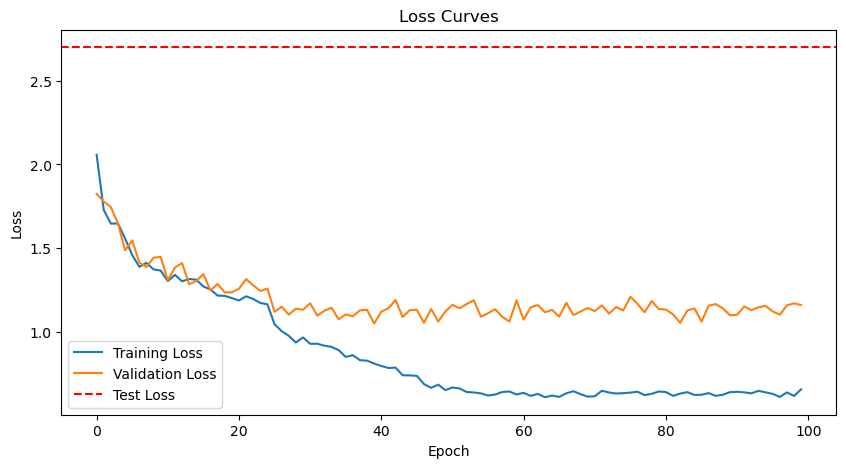

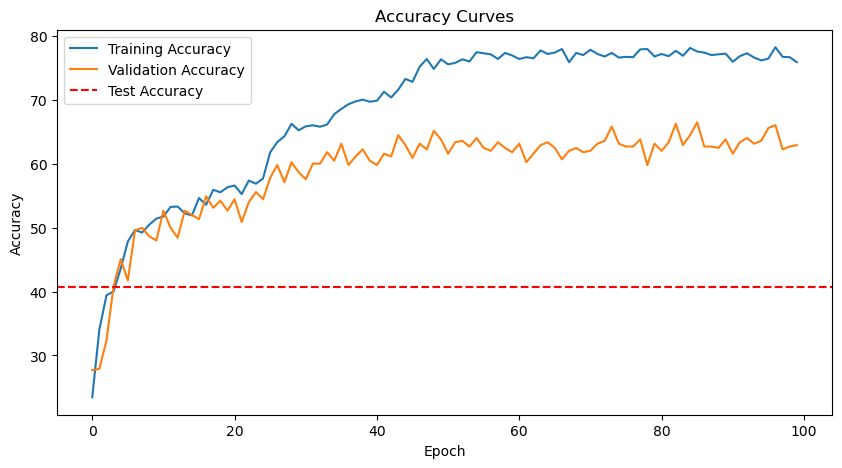

In [19]:
import matplotlib.pyplot as plt

# Plot training, validation, and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Add test loss as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Plot training, validation, and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Add test accuracy as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

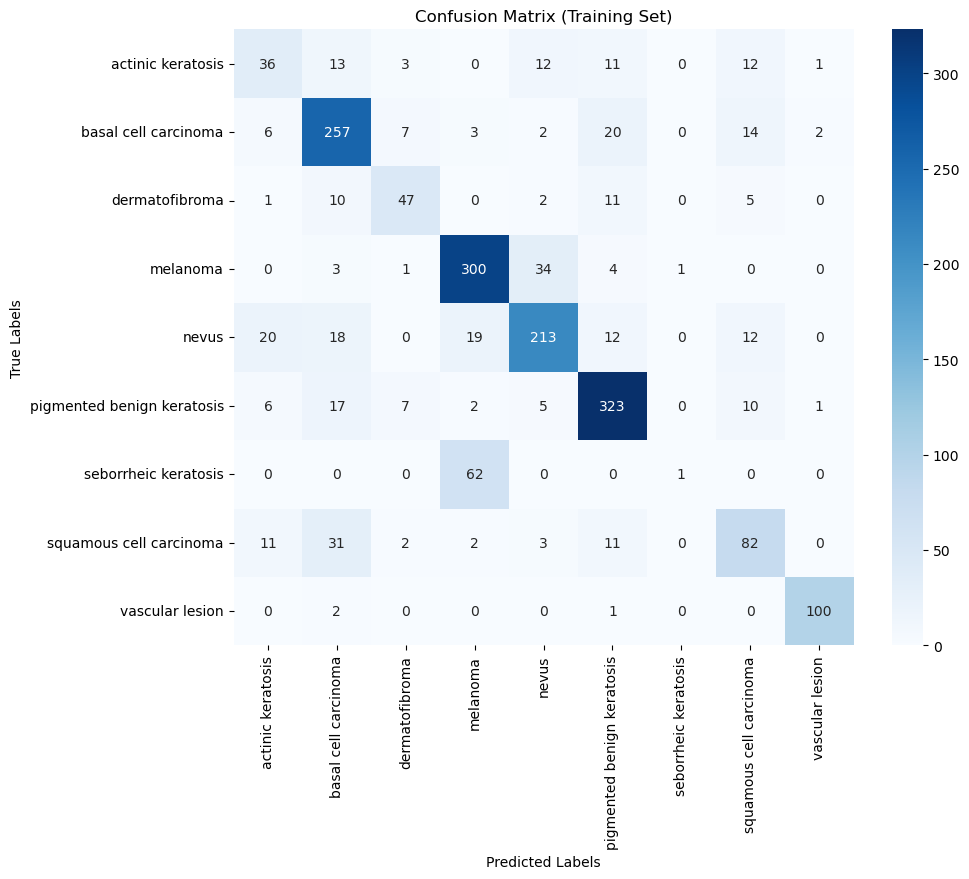

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Disable gradient computation for training set evaluation
with torch.no_grad():
    for images, labels in train_loader:  # Use train_loader instead of test_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the Vision Transformer model
        outputs = model(images)  # This will return an object, not just the logits
        
        # Access the logits from the model's output object
        logits = outputs.logits  # or use outputs['logits'] depending on the model output structure
        
        # Get predictions
        _, preds = torch.max(logits, 1)

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Training Set)')
plt.show()


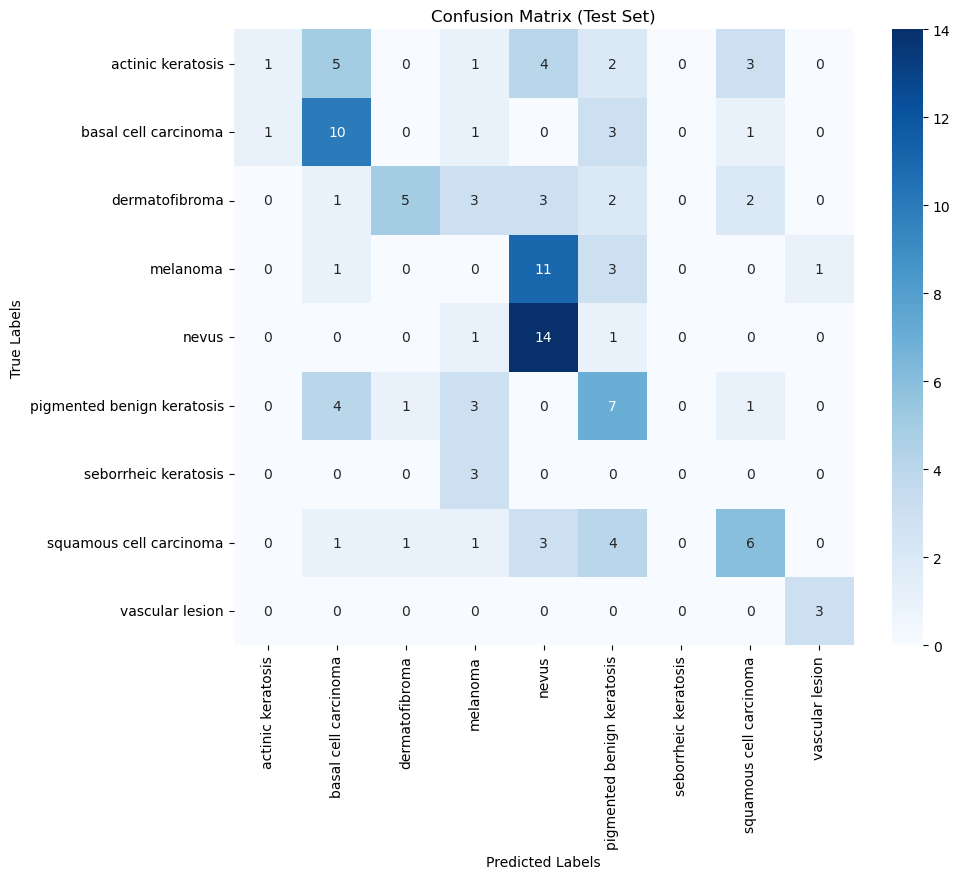

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for test data
all_preds_test = []
all_labels_test = []

# Disable gradient computation for test set evaluation
with torch.no_grad():
    for images, labels in test_loader:  # Use test_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the Vision Transformer model
        outputs = model(images)  # This will return an object, not just the logits
        
        # Access the logits from the model's output object
        logits = outputs.logits  # or use outputs['logits'] depending on the model output structure
        
        # Get predictions
        _, preds = torch.max(logits, 1)

        # Store predictions and labels
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

# Compute the confusion matrix for test data
cm_test = confusion_matrix(all_labels_test, all_preds_test)

# Plot the confusion matrix for test data
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Test Set)')
plt.show()


In [23]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for training data
all_preds_train = []
all_labels_train = []

# Disable gradient computation for training set evaluation
with torch.no_grad():
    for images, labels in train_loader:  # Use train_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the Vision Transformer model
        outputs = model(images)  # The model may output logits or a dictionary containing logits
        
        # Access the logits (adjust depending on your model's output structure)
        logits = outputs.logits  # or outputs['logits'] depending on the output
        
        # Get predictions
        _, preds = torch.max(logits, 1)

        # Store predictions and labels
        all_preds_train.extend(preds.cpu().numpy())
        all_labels_train.extend(labels.cpu().numpy())

# Compute F1 score, precision, and recall for training set
f1_train = f1_score(all_labels_train, all_preds_train, average='weighted')
precision_train = precision_score(all_labels_train, all_preds_train, average='weighted')
recall_train = recall_score(all_labels_train, all_preds_train, average='weighted')

# Print the results
print(f"Training F1 Score: {f1_train:.4f}")
print(f"Training Precision: {precision_train:.4f}")
print(f"Training Recall: {recall_train:.4f}")


Training F1 Score: 0.7592
Training Precision: 0.7700
Training Recall: 0.7733


In [24]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for test data
all_preds_test = []
all_labels_test = []

# Disable gradient computation for test set evaluation
with torch.no_grad():
    for images, labels in test_loader:  # Use test_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the ViT model
        outputs = model(images)  # The ViT model might output logits or a dictionary containing logits
        
        # Access the logits (adjust depending on your model's output structure)
        logits = outputs.logits  # or outputs['logits'] depending on the output structure of ViT
        
        # Get predictions
        _, preds = torch.max(logits, 1)

        # Store predictions and labels
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

# Compute F1 score, precision, and recall for test set
f1_test = f1_score(all_labels_test, all_preds_test, average='weighted')
precision_test = precision_score(all_labels_test, all_preds_test, average='weighted')
recall_test = recall_score(all_labels_test, all_preds_test, average='weighted')

# Print the results
print(f"Test F1 Score: {f1_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")


Test F1 Score: 0.3522
Test Precision: 0.4099
Test Recall: 0.3814


C:\Users\Amir\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
